## Préface

Dans ce travail pratique, les sources seront notées entre crochets ([X]) et détaillées dans la section *Médiagraphie* à la fin du document

## Constantes et modules

Définissons d'abord toutes les constantes qui seront utilisées par les fonction définies ci-après [1], et importons les modules nécessaires:

In [63]:
import math
import timeit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # peut être à enlever
from scipy.stats import moyal


c = 2.99792458 * 10**8                  # vitesse de la lumière [m/s]
re = 2.8179409238 * 10**(-15)           # rayon classique de l'électron [m]
me = 9.1093837015 * 10**(-31)           # masse au repos de l'électron [kg]
mp = 1.6726219236951 * 10**(-27)        # masse au repos du proton [kg]

## Densité électronique d'un milieu

En premier lieu, on cherche à déterminer la densité électronique pour un milieu donné, en nombre d'électrons par centimètre cube. Pour ce faire, on a besoin de trois données pour chaque composant distinct du milieu: le numéro atomique ($Z_n$), la fraction massique ($F_n$) et la masse volumique ($M_n$). Toutes ces données sont tabulées sur diverses pages web, notamment celle du NIST [2].

Pour obtenir la densité électronique à partir de ces trois données, on doit déterminer le nombre d'électrons de chaque composant distinct indépendamment. Cela se traduit mathématiquement par :

$$N_e=\sum_{i=1}^{n}\frac{\rho}{M_i}Z_i\cdot F_n\cdot N_A$$

Où $N_e$ est la densité électronique en $\text{électrons/cm}^3$, et $N_A=6.02214076\times10^{23}$ atomes/mol est le nombre d'Avogadro. On code cette expression dans la fonction *densiteelec* qui prend en entrée la masse volumique en $\text{g/cm}^3$ du milieu et une liste comprenant $Z$, $F$ et $M$ pour chaque composant du milieu et retourne la densité électronique en $\text{électrons/cm}^3$.

In [64]:
# Format de données: données = [[Z1, P1, M1], [Z2, P2, M2], ...]
# où Zn est le numéro atomique, Fn est la fraction massique et Mn est la masse volumique
# Chaque liste individuelle dans la liste "données" représente un composant
# distinct du milieu (par exemple, H et O pour l'eau).

def densiteelec(rho, donnees):
    nombreelec = []
    for i in donnees:
        nombreelec.append(i[1]*rho/i[2]*i[0]*6.02214076*10**(23))
    return sum(nombreelec)

Pouvant maintenant calculer les densités électroniques, il sera utile de les calculer et d'enregistrer ces valeurs dans un dictionnaire afin de pouvoir y accéder aisément plus tard. Définissons donc le dictionnaire *milieu*, qui contiendra trois valeurs : la densité électronique (que nous pouvons maintenant calculer), ainsi que la masse volumique et l'énergie d'excitation moyenne, toutes deux tirées directement du site du NIST [2]. Toutes les données utilisées pour faire les calculs de densité électronique ont aussi été tirées du site web du NIST:

In [65]:
# milieu = {"milieu1": (densité électronique [e/cm^3], rho [g/cm^3], énergie moy d'activation [J])}

rho_eau = 1
donnees_eau = [[1, 0.111894, 1.0079], [8, 0.888106, 15.999]]
I_eau = 75 / (6.242*10**18)

rho_os = 1.85
donnees_os = [
    [1, 0.063984, 1.0079], 
    [6, 0.278000, 12.011], 
    [7, 0.027000, 14.007], 
    [8, 0.410016, 15.999], 
    [12, 0.002000, 24.305], 
    [15, 0.070000, 30.974], 
    [16, 0.002000, 32.06], 
    [20, 0.147000, 40.078]
    ]
I_os = 91.9 / (6.242*10**18)

milieu = {}
milieu["eau"] = (densiteelec(rho_eau, donnees_eau), rho_eau, I_eau)
milieu["os"] = (densiteelec(rho_os, donnees_os), rho_os, I_os)

Lorsqu'on aura des fonctions qui feront appel à l'une de ces deux variables, on pourra donc simplement passer en argument le milieu dans lequel on souhaite évaluer la fonction; cela nous évitera d'avoir à "hard-code" des valeurs ou encore à programmer plusieurs fonctions distinctes. Les valeurs de densité électronique pour l'eau et l'os compact sont donc :

In [66]:
print("densité électronique de l'eau :", milieu["eau"][0], "électrons / cm^3")
print("densité électronique de l'os compact :", milieu["os"][0], "électrons / cm^3")

densité électronique de l'eau : 3.342876611513782e+23 électrons / cm^3
densité électronique de l'os compact : 5.9059477632844346e+23 électrons / cm^3


## Pouvoir d'arrêt

On veut maintenant coder une fonction qui calcule le pouvoir d'arrêt d'un milieu en fonction de l'énergie cinétique du proton qui s'y trouve. On sait que le pouvoir d'arrêt est donné par la fonction mathématique suivante :
$$S_{col}(T)=2\pi r_e^2 m_e c^2 n_e\beta^{-2}\left[\ln\left(\frac{2m_ec^2\beta^2\gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]$$
avec les quantités suivantes :
$$T^{max}_e = \frac{2m_ec^2(\gamma^2-1)}{1+\big(\frac{m_e}{m_p})^2 + 2\frac{m_e}{m_p}\gamma}$$
$$\gamma = \frac{T}{m_pc^2} + 1$$
$$\beta = \sqrt{1-\gamma^{-2}}$$
où $r_e$ est le rayon classique de l'électron, $n_e$ est la densité électronique du milieu, $Z$ est la charge de la particule, $I$ est l'énergie moyenne d'excitation du milieu et $T$ est l'énergie cinétique de la particule. On commence par coder une fonction qui retourne l'énergie maximale transférable $T_e^{max}$ :

In [67]:
def e_transf_max(gamma):
    te_max = 2 * me * c**2 * (gamma**2 - 1) / (1 + 2*gamma*me/mp + (me/mp)**2)
    return te_max

On définit ensuite la fonction *pouvoir_arret* qui retourne le pouvoir d'arrêt pour un proton en fonction du milieu et de l'énergie cinétique du proton en MeV. Tout d'abord, la fonction convertit l'énergie cinétique et la densité électronique en unités SI. Elle calcule ensuite les quantités $\gamma$, $\beta$ et $T_e^{max}$. Finalement elle calcule le pouvoir d'arrêt et retourne la valeur convertie en MeV.

In [68]:
# Pouvoir d'arrêt [MeV/m]
# Arguments :
# T : énergie cinétique du proton [MeV]
# mil : clé pour appeler le bon milieu dans le dictionnaire "milieu" ("eau" ou "os")

def pouvoir_arret(T, mil): 

    # T de MeV à J
    T = T / 6241506479963.2

    # densité électronique de g/cm-3 à kg/m-3
    ne = milieu[mil][0]*10**6

    # Calcul de gamma et beta
    gamma = T / (mp * c**2) + 1
    beta = np.sqrt(1 - gamma**(-2))

    # Calcul de l'énergie de transfert maximal
    te_max = e_transf_max(gamma)

    const = 2 * np.pi * re**2 * me * c**2 * ne / beta**2
    parenth = np.log(2 * me * c**2 * gamma**2 * te_max / milieu[mil][2]**2) - (2 * beta**2)

    return (const * parenth) * 6241506479963.2

Maintenant qu'on a une fonction qui permet de calculer le pouvoir d'arrêt, on peut tracer le pouvoir d'arrêt en fonction de l'énergie cinétique du proton pour l'eau liquide et pour l'os compact. On considère un intervalle de 3-250 MeV pour l'énergie cinétique du proton, car les faisceaux de protonthérapie ont typiquement une énergie cinétique initiale de 70-250 MeV et car notre modèle théorique ne s'applique pas pour des protons avec une énergie cinétique de moins de 3 MeV.

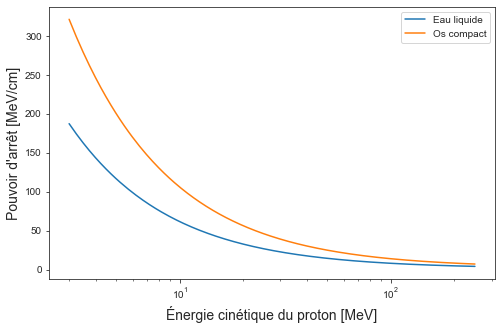

In [69]:
# Énergie cinétique du proton
T = np.linspace(3, 250, 1000)

# Pouvoir d'arrêt de l'eau liquide en MeV/cm
pouv_arr_eau = []
for i in T:
    pouv_arr_eau.append(pouvoir_arret(i, 'eau') / 100)

# Pouvoir d'arrêt de l'os compact en MeV/cm
pouv_arr_os = []
for i in T:
    pouv_arr_os.append(pouvoir_arret(i, 'os') / 100)

sns.set_style("ticks")
pouv_arr_fig = plt.figure(figsize=(8,5))
plt.plot(T, pouv_arr_eau, label='Eau liquide')
plt.plot(T,pouv_arr_os, label='Os compact')
plt.xlabel('Énergie cinétique du proton [MeV]', fontsize=14)
plt.ylabel("Pouvoir d'arrêt [MeV/cm]", fontsize=14)
plt.xscale('log')
plt.legend()
plt.show()

On remarque d'abord que, dans les deux milieux, le pouvoir d'arrêt diminue lorsque l'énergie cinétique du proton est faible. Nous verrons que cette propriété est utile en protonthérapie. Aussi, Le pouvoir d'arrêt est plus élevé dans l'os compact que dans l'eau liquide.

Il est pertinent de souligner que le modèle ne considère que l'effet de l'interaction entre les électrons et les protons sur le pouvoir d'arrêt. Toutefois, cette approximation est légitime, car cet effet dépasse largement les autres effets qui influencent le pouvoir d'arrêt. Les deux autres phénomènes principaux sont l'effet Bremsstrahlung, qui cause des pertes radiatives, et l'interaction entre les protons et les noyaux atomiques. Selon les données du NIST [3] représentées à la figure 1, on observe que l'effet de l'interaction entre les protons et les noyaux atomiques dans l'os compact est faible comparée à l'interaction entre les protons et les électrons, spécialement pour la plage d'intérêt, c'est-à-dire pour une énergie cinétique de 3 à 250 MeV. Les données du NIST pour l'eau liquide représentées à la figure 2 montrent un comportement similaire. Par exemple, pour une énergie cinétique de 100 MeV, selon le NIST, les pertes causées par l'interaction proton-électron dans l'eau liquide sont de 45,6 MeV tandis que les pertes causées par l'intéraction proton-noyaux atomiques est de 26,0 keV. Les pertes causées par les interactions avec les électrons sont donc environ 1754 fois plus grandes que celles causées par les interactions avec les noyaux atomiques dans cette situation.

<center><img src="PouvoirArretTotalOS.png" style="width: 600px;"/></center>
<center>Figure 1. Pouvoir d'arrêt pour un proton dans l'os compact [3]


<center><img src="PouvoirArretTotalEau.png" style="width: 600px;"/></center>
<center>Figure 2. Pouvoir d'arrêt pour un proton dans l'eau liquide [3]

Pour l'effet Bremsstrahlung, on peut déterminer l'ordre de grandeur des pertes radiatives des protons à partir des données sur les pertes radiatives des faisceaux d'électrons dans les différents milieux. Selon les données du NIST [4], les pertes radiatives maximales pour un faisceau d'électron dans l'eau liquide pour des énergies de 3 à 250 MeV sont de l'ordre de 1 MeV. Pour un faisceau de protons, la force électromagnétique issue de l'intéraction entre les protons et les électrons sera du même ordre de grandeur que pour un faisceau d'électrons, mais, comme la masse du proton est environ 1836 fois plus grande que celle de l'électron [1], l'accélération des protons sera alors environ 1836 fois plus petit par la deuxième loi de Newton. Comme l'accélération cause les pertes radiatives, celles-ci seront également 1836 fois plus petites que pour un faisceau d'électrons. Les pertes seront alors de l'ordre du keV et seront négligeables comparées aux pertes dues aux interactions proton-électron, qui sont de l'ordre du MeV. On peut effectuer le même raisonnement pour l'os compact à partir des données du NIST et en arriver à la même conclusion.

## Portée des protons dans la matière

On cherche maintenant à déterminer la portée des protons dans l'eau liquide et l'os compact. On sait que la portée est donnée par l'intégrale suivante :
$$R_{CSDA}=\rho\int_0^{T_i}\frac{1}{S_{col}}$$
Comme le pouvoir d'arrêt du milieu représente la quantité d'énergie que le proton perd lorsqu'il se propage dans le milieu, on voit logiquement que le proton pourra se propager plus loin si le pouvoir d'arrêt du milieu est faible. Il se propagera moins loin si le pouvoir d'arrêt est grand. Il est donc cohérent d'intégrer sur l'inverse du pouvoir d'arrêt afin de déterminer la portée du proton.

On veut maintenant déterminer si on doit utiliser une méthode numérique pour calculer l'intégrale. Tout d'abord, on peut réécrire l'équation du pouvoir d'arrêt en fonction de $\gamma$ à l'aide des relations suivantes:
$$U = 2\pi r_e^2m_ec^2n_e$$
$$T = (\gamma-1)m_pc^2$$
$$T_e^{max} = \frac{a(\gamma^2-1)}{b + \delta\gamma}$$
$$\beta^2\gamma^2 = (\gamma^2-1)$$
où $a$, $b$ et $\delta$ sont des constantes qui dépendent des masses de l'électron et du proton. On En remplaçant dans dans l'équation du pouvoir d'arrêt, on a
$$S_{col} = U\frac{\gamma^2}{(\gamma^2-1)}\Bigg[\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta)}\bigg)\Bigg] - 2U$$
En posant les changements de variable d'intégration $T = T_i - T$ et $T = (\gamma-1)m_pc^2$, on obtient une intégrale de la forme suivante pour la portée:
$$R_{CSDA} = \rho m_pc^2\int \frac{\text{d}\gamma}{U\frac{\gamma^2}{(\gamma^2-1)}\Bigg[\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta)}\bigg)\Bigg] - 2U}$$
Une intégrale de cette forme ne possède pas de solution analytique connue, donc on doit la résoudre numériquement. On peut vérifier qu'elle n'a pas de solution analytique avec un logiciel de calcul tel que WolframAlpha. Pour calculer l'intégrale numériquement, on veut utiliser deux méthodes d'intégration numérique : la méthode des trapèzes et la méthode de Romberg. Implémentons d'abord la méthode des trapèzes, étant donné que celle-ci sera nécessaire au fonctionnement de la méthode de Romberg :

In [70]:
# Intègre une fonction selon la méthode des trapèzes
# Arguments:
# f : fonction à intégrer
# N : nombre de tranches
# a, b : bornes d'intégration
# *args : arguments supplémentaires de f

def trapeze(f, N, a, b, *args):
    h = (b-a)/N

    s = 0.5*f(a, *args)+0.5*f(b, *args)
    for i in range(1,N):
        s += f(a+i*h, *args)
    
    return h*s

Cette fonction prend en argument la fonction à intégrer f, le nombre de tranches N, les deux bornes d'intégration a et b, ainsi que des arguments optionnels propre à la fonction à intégrer. Elle retourne la valeur de l'intégrale calculée par la méthode des trapèzes.

On peut maintenant implémenter la méthode de Romberg. En partant de $N=2$ tranches, la fonction calcule l'intégrale par la méthode des trapèzes de façon itérative pour le double de tranches à chaque itération jusqu'à obtenir le nombre de tranches maximal souhaité. Pour la $i$-ième valeur donnée par la méthode des trapèzes, elle calcule $i$ valeurs $R_{i,m}$ plus précises de l'intégrales de manière itérative par l'équation suivante [5] :
$$R_{i, m+1} = R_{i,m} + \frac{1}{4^m-1}(R_{i,m}-R_{i-1,m})$$
La fonction retourne ensuite la dernière valeur calculée, qui correspond à la valeur la plus précise. La fonction retourne également l'erreur sur l'avant-dernière itération telle que donnée par l'équation suivante [5] :
$$\epsilon = \frac{1}{4^m-1}(R_{i,m}-R_{i-1,m}) + \mathcal{O}(h^{2m+2}_i)$$
où les termes en $\mathcal{O}(h^{2m+2}_i)$ sont négligés. Comme la dernière itération sera plus précise que l'avant-dernière, on peut utiliser cette valeur d'erreur surestimée pour la dernière itération. Malheureusement, on ne peut pas calculer directement de cette façon l'erreur sur la dernière itération, car si $m=i$, alors la quantité $R_{i-1,m}$ n'existe pas.

In [71]:
# Intègre une fonction selon la méthode de Romberg
# Retourne la valeur de l'intégrale et l'erreur
# Arguments:
# f : fonction à intégrer
# i_max : nombre d'itérations (2^i tranches au maximum)
# a, b : bornes d'intégration
# *args : arguments supplémentaires de f

def romberg(f, i_max, a, b, *args):
    Rn = []
    N = 1
    for i in range(i_max):
        Rn.append([trapeze(f, N, a, b, *args)])
        N = 2 * N
        for m in range(i):
            Rn[i].append(Rn[i][m] + (Rn[i][m] - Rn[i-1][m]) / (4**(m+1) - 1))
    err = (Rn[-1][-2] - Rn[-2][-1]) / (4**(i_max-1) - 1)
    return Rn[-1][-1], err

On veut maintenant, à l'aide de ces deux algorithmes, évaluer la portée des protons dans l'eau et dans l'os compact. La portée est donnée par :

$$R_{CSDA}=\rho\int_0^{T_i}\frac{1}{S_{col}}$$

Où $\rho$ est la masse volumique du milieu en $\text{kg/m}^3$, $T_i$ est l'énergie d'entrée du proton en MeV, et $S_{col}$ est le pouvoir d'arrêt en MeV par mètre. On définit donc tout d'abord une fonction qui retourne l'inverse du pouvoir d'arrêt. On définit ensuite une fonction *portee* qui peut calculer la portée d'un proton par la méthode des trapèzes ou par la méthode de Romberg. Cette fonction prend en argument un paramètre $i$ qui fixe à $2^i$ le nombre de tranches pour la méthode des trapèzes et le nombre de tranches maximal pour la méthode de Romberg, le nom du milieu, les bornes d'intégration et la méthode (trapèzes ou Romberg).

In [72]:
# Retourne l'inverse du pouvoir d'arrêt
# Arguments :
# T : énergie cinétique du proton
# mil : nom du milieu de propagation ("eau" ou "os")

def inv_pouvoir_arret(T, mil):
    return pouvoir_arret(T, mil)**(-1)

# Calcule la portée
# Arguments :
# T : énergie cinétique du proton
# a, b : énergie cinétique finale et initiale du proton
# mil : nom du milieu de propagation ("eau" ou "os")

def portee(i, a, b, mil, methode):
    N = 2 ** i
    if methode == "trapeze":
        return milieu[mil][1] * 1000 * trapeze(inv_pouvoir_arret, N, a, b, mil)
    elif methode == "romberg":
        return milieu[mil][1] * 1000 * romberg(inv_pouvoir_arret, i, a, b, mil)[0]

Il est à noter que puisque les éléments de chaque liste du dictionnaire *dens* (défini au début du document) sont en $\text{électrons/cm}^3$ et en $\text{g/cm}^3$ respectivement; il est donc important de se rappeler de les convertir de façon appropriée dans les fonctions.

On peut donc spécifier tous les paramètres pour obtenir la portée. Si par exemple on veut la portée dans l'os compact avec la méthode des trapèzes, avec $N=2^8=256$ tranches avec une énergie variant de 150 MeV à 3 MeV, on écrira :

In [73]:
print("portée dans l'os compact avec la méthode des trapèzes =", portee(8, 3, 150, "os", "trapeze"))
print("portée dans l'os compact avec la méthode de Romberg =", portee(8, 3, 150, "os", "romberg"))

print("portée dans l'eau avec la méthode des trapèzes =", portee(8, 3, 150, "eau", "trapeze"))
print("portée dans l'eau avec la méthode de Romberg =", portee(8, 3, 150, "eau", "romberg"))

portée dans l'os compact avec la méthode des trapèzes = 150.69925754693503
portée dans l'os compact avec la méthode de Romberg = 150.69949600159725
portée dans l'eau avec la méthode des trapèzes = 140.52300172393768
portée dans l'eau avec la méthode de Romberg = 140.5232220245214


Maintenant, on veut estimer le nombre de tranches nécessaires pour atteindre la précision machine pour chacune de ces méthodes. On prendra, comme suggéré dans les notes de cours, une valeur conservatrice de $10^{-16}$ pour l'erreur d'arrondi et on estimera le nombre de tranches nécessaires pour que l'erreur d'approximation se retrouve en déça de cette valeur.

Tout d'abord, on s'attaque à la méthode des trapèzes. On peut tirer du Newmann [6] une expression estimant l'erreur d'approximation commise par une intégration numérique, soit :

$$\epsilon_{2N}=\frac{1}{3}(I_{2N}-I_N)$$

On cherche donc la valeur 2N pour que l'expression suivante soit vraie:

$$\frac{1}{3}(I_{2N}-I_N) < 10^{-16}$$

On peut programmer une fonction qui détermine ce nombre 2N de tranches par itération. On débutera donc en évaluant la fonction à 1 et 2 tranches, puis nous augmenterons le nombre de tranches de 10% à chaque évaluation de la fonction.

In [74]:
# Estimation le nombre de tranches requises pour atteindre la
# précision machine avec la méthode des trapèzes
# Arguments:
# Ni: nombre initial de tranches à la première itération
# a, b: énergie cinétique finale et initiale du proton
# mil: milieu ("eau" ou "os")
# pas: facteur multiplicatif du nombre de tranches à chaque itération

def estim_trapeze(Ni, a, b, mil, pas, precision):
    N = Ni
    I1 = 0
    I2 = trapeze(inv_pouvoir_arret, N, a, b, mil) * 1000 * milieu[mil][1]
    while (I2 - I1)/3 > precision:
        N = math.ceil(N*pas)
        I1 = I2
        I2 = trapeze(inv_pouvoir_arret, N, a, b, mil) * 1000 * milieu[mil][1]
    return N

Si on veut estimer le nombre de tranches requises pour l'eau, on aura donc:

In [13]:
# ATTENTION : Le code cette cellule a été commenté, car il prend trop de temps à s'exécuter!

#nb = estim_trapeze(1, 0, 150, "eau", 1.15, 1*10**(-16))
#print("Estimé du nombre de tranches requises:",nb)

On remarque rapidement que la fonction ne semble pas trouver le nombre de tranches requises dans un itervalle de temps raisonnable. Même si on laisse le code fonctionner pendant plus d'une heure, on n'a toujours pas de sortie. Évaluons l'erreur à un milliard de tranches:

In [14]:
N1 = 500000000
N2 = 1000000000
I1 = trapeze(inv_pouvoir_arret, N1, 0, 150, "eau") * 1000 * milieu["eau"][1]
I2 = trapeze(inv_pouvoir_arret, N2, 0, 150, "eau") * 1000 * milieu["eau"][1]
err = np.abs(I2 - I1)/3
print("l'erreur à un milliard de tranches est de",err)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


Ce qui n'est pas du tout près de l'ordre de grandeur requis pour atteindre la précision machine. On peut donc conclure tentativement qu'il n'est pas raisonnable de pousser le calcul avec la méthode des trapèzes jusqu'à obtenir la précision machine: le temps de calcul serait extrêmement élevé. Cependant, au #6, il est demandé d'effectuer un graphique comportant l'estimation de l'erreur en fonction du nombre de tranches. On se réfèrera donc à ce graphique une fois qu'il sera fait, et nous reviendrons sur notre conclusion quant au nombre de tranches requises pour la méthode des trapèzes.

On implémente maintenant la fonction évaluant le nombre de tranches nécessaires pour obtenir la précision machine avec la méthode de Romberg. La précision est la même que précédemment, alors on conserve le critère que l'erreur estimée doit être inférieure à $10^{-16}$. Étant donné que la méthode de Romberg emploie la méthode des trapèzes, l'estimation de l'erreur est la même. Cependant, le nombre de tranches utilisées par la méthode de Romberg est égal à $N=2^{i_{max}}$. Comme la fonction de la méthode de Romberg retourne déjà l'erreur sur l'intégrale, on peut simplement réécrire la méthode de Romberg de façon à ce qu'elle boucle tant que la précision recherchée n'est pas atteinte :

In [75]:
# Estimation le nombre de tranches requises pour atteindre la
# précision machine avec la méthode de Romberg
# Arguments:
# imax_i: dimensions initiales de la matrice de Romberg
# a, b: énergie cinétique finale et initiale du proton
# mil: milieu ("eau" ou "os")

def estim_romberg(imax_i, a, b, mil, precision):
    i_max = imax_i
    err = romberg(inv_pouvoir_arret, i_max, a, b, mil)[1] * 1000 * milieu[mil][1]
    while err > precision:
        i_max += 1
        err = romberg(inv_pouvoir_arret, i_max, a, b, mil)[1] * 1000 * milieu[mil][1]
    return i_max


i_eau = estim_romberg(2, 3, 150, "eau", 1*10**(-16))
print("Estimé du nombre de tranches requises:",(2**i_eau))

Estimé du nombre de tranches requises: 2048


On constate qu'on atteint la précision machine beaucoup plus rapidement avec la méthode de Romberg: il faut seulement *i_max*=11, soit $N=2^{i_{max}}=2048$ tranches afin d'atteindre la précision machine.

#### Portée et erreur en fonction du nombre de tranches

On peut grapher la portée et l'erreur estimée en fonction du nombre de tranches pour les deux méthodes. On programme donc une fonction *donnees* qui itère sur la méthode souhaitée et qui retourne une liste des portées et des erreurs estimées à chaque itération. On double le nombre de tranches à chaque itération (ce qui correspond à doubler *N* pour la méthode des trapèzes et à augmenter *i* de 1 pour la méthode de Romberg).

In [76]:
# Retourner sous forme de liste la portée et l'erreur estimée à chaque itération de la fonction
# Arguments:
# a, b: énergie cinétique finale et initiale du proton
# mil: milieu ("eau" ou "os")
# methode: méthode d'intégration ("trapeze" ou "romberg")
# max: nombre maximal d'itérations de la fonction

def donnees(a, b, mil, methode, max):
    max = int(max)
    N = 1
    liste_portee = []
    liste_err = []
    if methode == "trapeze":
        port1 = 0
        for n in range(max+1):
            port2 = milieu[mil][1] * 1000 * trapeze(inv_pouvoir_arret, N, a, b, mil)
            err = (port2 - port1)/3
            liste_portee.append(port2)
            liste_err.append(abs(err))
            N = N*2
            port1 = port2
    elif methode == "romberg":
        for n in range(max):
            N += 1
            liste_portee.append(1000*milieu[mil][1]*romberg(inv_pouvoir_arret, N, a, b, mil)[0])
            liste_err.append(abs(1000*milieu[mil][1]*romberg(inv_pouvoir_arret, N, a, b, mil)[1]))
    return liste_portee, liste_err

À titre d'exemple, prenons l'os compact. On doit choisir une valeur de *max* qui correspond au nombre fois qu'on doublera les tranches avant que la fonction s'arrête, tel que le nombre de tranches maximal est $N=2^{max}$ (en se souvenant que le temps d'éxécution augmente exponentiellement à chaque fois qu'on augmente *max*).

On éxécute la fonction *donnees* une fois pour chaque méthode, en insérant au premier élément des listes de la méthode de Romberg les valeurs obtenues avec la méthode des trapèzes (la méthode de Romberg se réduit à la méthode des trapèzes lorsque $i_{max}=1$ étant donné que la matrice de Romberg devient une matrice 1x1, soit simplement un scalaire). On produit aussi *liste_tranches*, une liste contenant le nombre de tranches calculées à chaque itération de la fonction, qui constituera l'axe horizontal du graphique.

In [77]:
max = 10

portee_trapeze, err_trapeze = donnees(3, 150, "os", "trapeze", max)
portee_romberg, err_romberg = donnees(3, 150, "os", "romberg", max)
portee_romberg.insert(0, portee_trapeze[0])
err_romberg.insert(0, err_trapeze[0])
liste_tranches = [2**n for n in range(max+1)]

À l'aide des données obtenues, on peut grapher les erreurs et la portée pour chaque fonction. Étant donné que la portée converge rapidement et que l'erreur diminue aussi très rapidement, le graphique sera en échelle logarithmique, qui permet mieux d'examiner le comportement des courbes.

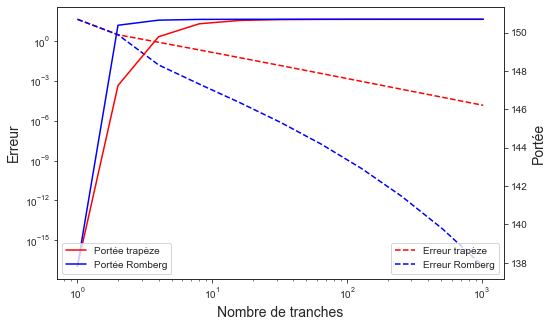

<Figure size 432x288 with 0 Axes>

In [78]:
sns.set_style("ticks")
portee_fig, ax = plt.subplots(figsize=(8,5))

# On graphe les erreurs
ax.plot(liste_tranches, err_trapeze, label='Erreur trapèze', linestyle='dashed', color='red')
ax.plot(liste_tranches, err_romberg, label='Erreur Romberg', linestyle='dashed', color='blue')
ax.set_xlabel('Nombre de tranches', fontsize=14)
ax.set_ylabel("Erreur", fontsize=14)

# Pour une meilleure lisibilité, le graphique doit être en log-log
ax.set_xscale('log')
ax.set_yscale('log')

# On crée un autre axe pour grapher la portée
ax2 = ax.twinx()
ax2.plot(liste_tranches, portee_trapeze, label='Portée trapèze', color='red')
ax2.plot(liste_tranches, portee_romberg, label='Portée Romberg', color='blue')
ax2.set_ylabel("Portée", fontsize=14)

# On positionne la légende
ax.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.show()

plt.savefig('portee_err.png')

Tel qu'attendu, l'erreur pour la méthode de Romberg descend beaucoup plus rapidement que pour la méthode des trapèzes. La méthode de Romberg converge aussi plus rapidement vers une valeur stable.

## Estimation analytique de l'erreur

On veut maintenant déterminer de façon analytique l'erreur pour la méthode des trapèzes. Pour ce faire, on doit connaître la dérivée analytique de la fonction à intégrer, donc on doit connaître la dérivée analytique du pouvoir d'arrêt. On utilise l'expression pour le pouvoir d'arrêt en fonction de $\gamma$ déterminée plus haut :
$$S_{col} = U\frac{\gamma^2}{(\gamma^2-1)}\Bigg[\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg)\Bigg] - 2U$$
On désire utiliser la formule pour la dérivée d'une multiplication et la dérivation en chaîne. On calcule les dérivées nécessaires:
$$\frac{\text{d}}{\text{d}\gamma} \frac{\gamma^2}{\gamma^2-1} = \Bigg(\frac{2\gamma}{\gamma^2-1} - \frac{2\gamma^3}{(\gamma^2-1)^2}\Bigg) = \frac{-2\gamma}{(\gamma^2-1)^2}$$
$$\frac{\text{d}}{\text{d}\gamma} \ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg)= \frac{I^2(b+\delta\gamma)}{2m_ec^2a(\gamma^2-1)} \Bigg(\frac{8m_ec^2a\gamma(\gamma^2-1)}{I^2(b+\delta\gamma)} - \frac{2\delta}{\delta(b+\delta \gamma)}\Bigg)$$
$$\frac{\text{d}}{\text{d}\gamma} \ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg) = \Bigg(\frac{4\gamma}{\gamma^2-1} - \frac{\delta}{\delta(b+\delta \gamma)}\Bigg)$$
$$\frac{\text{d}\gamma}{\text{d}T} = \frac{1}{m_pc^2}$$
On peut alors déterminer la dérivée première du pouvoir d'arrêt:
$$\frac{\text{d}S_{col}}{\text{d}T} = \frac{\text{d}S_{col}}{\text{d}\gamma}\frac{\text{d}\gamma}{\text{d}T}$$
$$\frac{\text{d}S_{col}}{\text{d}T} = \frac{U}{m_pc^2}\Bigg[\frac{-2\gamma}{(\gamma^2-1)^2}\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg) + \frac{\gamma^2}{(\gamma^2-1)}\Bigg(\frac{4\gamma}{\gamma^2-1} - \frac{\delta}{b+\delta \gamma}\Bigg)\Bigg]$$
$$\frac{\text{d}S_{col}}{\text{d}T} = \frac{U}{m_pc^2}\frac{\gamma}{(\gamma^2-1)^2}\Bigg[4\gamma^2 - 2\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg) - \frac{\delta\gamma(\gamma^2-1)}{b+\delta\gamma}\Bigg]$$

On définit maintenant une fonction pour déterminer analytiquement l'erreur sur l'intégration par la méthode des trapèzes en utilisant la dérivée de la fonction à intégrer. On sait que la formule qui donne l'erreur correspond à [6] :
$$\epsilon = \frac{1}{12}\bigg(\frac{N}{b-a}\bigg)^2(f'(a)-f'(b))$$
On code la fonction :

In [79]:
# Retourne l'erreur analytique pour la méthode des trapèzes
# Arguments :
# f : dérivée de la fonction à intégrer
# N : nombre de tranches de la méthode des trapèzes
# a, b : bornes d'intégration
# *args : autres arguments de f

def erreur_trapeze(f, N, a, b, *args):
    return 1/12 * (N / (b - a))**2 * (f(a, *args) - f(b, *args))

Dans le cas présent, la dérivée du pouvoir d'arrêt a déjà été déterminée analytiquement. On code la fonction *dS_dT*, qui correspond à la dérivée du pouvoir d'arrêt déterminée analytiquement. Celle-ci fonctionne de la même façon que la fonction *pouvoir_arret* et prend les mêmes arguments. On définit par la suite la dérivée de l'intégrande selon l'équation suivante :
$$\frac{\text{d}}{\text{d}T}\frac{1}{S_{col}} = -\frac{1}{(S_{col})^2}\bigg(\frac{\text{d}S_{col}}{\text{d}T}\bigg)

In [80]:
# Retourne la dérivée du pouvoir d'arrêt
# Arguments :
# T : énergie cinétique du proton
# mil : milieu de propagation ("eau" ou "os")

def dS_dT(T, mil):
    T = T / 6241506479963.2
    ne = milieu[mil][0]*10**6
    gamma = T / (mp*c**2) + 1
    a = 2*me*c**2
    b = 1 + (me/mp)**2
    d = 2 * (me/mp)
    return 2*np.pi*re**2*me*ne*1000 / mp * gamma / (gamma**2-1) * (4*gamma**2 - 2*np.log(2*me*c**2*a*(gamma-1) / (milieu[mil][2]**2*(b+d))) - (d*gamma*(gamma**2-1)) / (b + d*gamma))

# Retourne la dérivée de l'intégrande dans l'équation de la portée
# Arguments :
# T : énergie cinétique du proton
# mil : milieu de programmation ("eau" ou "os")

def derivee_integrande(T, mil):
    return -milieu[mil][1]*1000 * inv_pouvoir_arret(T, mil)**2 * dS_dT(T, mil)

On peut donc déterminer analytiquement l'erreur sur la portée des protons avec une énergie de 150 MeV déterminée par la méthode des trapèzes avec 256 tranches :

In [81]:
print("erreur sur la méthode des trapèzes dans l'eau :", erreur_trapeze(derivee_integrande, 256, 0.1, 150, "eau"))
print("erreur sur la méthode des trapèzes dans l'os compact :", erreur_trapeze(derivee_integrande, 256, 0.1, 150, "os"))

erreur sur la méthode des trapèzes dans l'eau : -0.6182191672067192
erreur sur la méthode des trapèzes dans l'os compact : -0.6590463628407133


## Optimisation

On veut maintenant comparer les performances des différentes méthodes d'intégration à des fins d'optimisation. Dans cette section, comme le milieu n'a pas d'impact sur la performance, tous les calculs sont effectués en considérant que le milieu est l'eau liquide. Tout d'abord, on génère aléatoirement une distribution de 10 000 protons où l'énergie cinétique initiale est donnée par une distribution de Moyal et on la représente sur un histogramme :

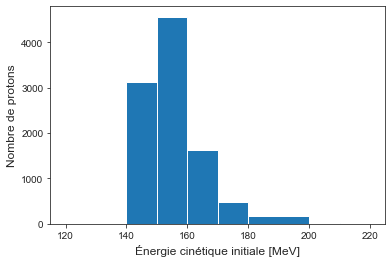

In [82]:
# On définit la distribution de Moyal et on prend un échantillon de 10 000 protons
sample = moyal(loc=150, scale=4).rvs(size=10000)

# On représente l'échantillon sur un histogramme
sns.set_style("ticks")
plt.figure(figsize=(6,4))
groupes = [120, 130, 140, 150, 160, 170, 180, 200, 210, 220]
plt.hist(sample, bins=groupes)
plt.xlabel('Énergie cinétique initiale [MeV]', fontsize=12)
plt.ylabel('Nombre de protons', fontsize=12)
plt.show()

Pour pouvoir bien comparer les performances des différentes méthodes d'intégration, on doit faire en sorte que la précision de chaque méthode est similaire. Une précision plus grande implique généralement un temps de calcul plus grand pour une même méthode, donc il est souhaitable de comparer les méthodes lorsqu'elles donnent des résultats avec la même précision. Comme on veut comparer la méthode des trapèzes, la méthode de Romberg et la méthode *scipy.integrate.quad*, on va se fier sur la précision de cette dernière pour ajuster le nombre de tranches des deux autres méthodes. La méthode *scipy.integrate.quad* retourne aussi l'incertitude sur l'intégrale, donc on peut calculer cette incertitude pour les 10 000 protons et déterminer l'incertitude moyenne. Pour intégrer avec *scipy*, on doit par contre avoir une fonction à un argument, donc on définit la fonction *integrande*. On utilise ensuite les fonctions définies plus haut pour déterminer le nombre de tranches nécessaires pour atteindre cette précision pour les deux autres méthodes. On choisit arbitrairement d'utiliser l'eau liquide comme milieu pour comparer les méthodes, mais ce choix ne devrait pas affecter les performances.

In [83]:
# Erreur moyenne de scipy

erreur_scipy = []

def integrande(T):
    return 1000 * milieu['eau'][1] * inv_pouvoir_arret(T, 'eau')

for i in sample:
    erreur_scipy.append(sp.integrate.quad(integrande, 0, i)[1])

err_sp = sum(erreur_scipy) / len(erreur_scipy)

print("Erreur moyenne de scipy :", err_sp)

Erreur moyenne de scipy : 2.793616973093549e-08


In [84]:
# Nombre de tranches, méthode des trapèzes

N_trap = estim_trapeze(2, 3, 150, "eau", 1.15, err_sp)
i_romb = estim_romberg(2, 3, 150, "eau", err_sp)
print(i_trap, i_romb)

7502 7


On veut ensuite déterminer le nombre de portées de protons que chaque méthode d'intégration peut calculer en 1 seconde. Pour ce faire, on utilise le module *timeit* pour calculer le temps nécessaire pour calculer les 10 000 portées pour chaque méthode d'intégration. On utilise la fonction *default_timer* qui retourne une valeur de temps au moment où elle est appelée. On prend donc une mesure de temps avant et après avoir appelé chaque méthode d'intégration avec le bon nombre de tranches et on soustrait les deux valeurs pour obtenir le temps nécessaire au calcul. Pour la méthode des trapèzes, on utilise $2^{13}=8192$ tranches pour avoir au moins la précision requise. Pour la méthode des trapèzes, par contre, comme le temps de calcul est très long, on calcule seulement les 100 premières portées. On détermine ensuite le temps nécessaire pour la méthode de Romberg et pour la méthode *scipy.integrate.quad* pour les 10 000 protons. On divise ensuite 10 000 (ou 100) protons par le temps obtenu pour connaître le nombre de protons par seconde pour chaque méthode.

In [102]:
# Méthode des trapèzes

portees_trapeze = []

t_1 = timeit.default_timer()
for p in sample[:100]:
    portees_trapeze.append(portee(13, 0, p, 'eau', 'trapeze'))
t_2 = timeit.default_timer()


# Méthode de Romberg

portees_romberg = []

t_3 = timeit.default_timer()
for p in sample:
    portees_romberg.append(portee(i_romb, 0, p, 'eau', 'romberg'))
t_4 = timeit.default_timer()


# Fonction scipy.integrate.quad

portees_scipy = []

t_5 = timeit.default_timer()
for p in sample:
    portees_scipy.append(sp.integrate.quad(integrande, 0, p)[0])
t_6 = timeit.default_timer()


print("Temps pour la méthode des trapèzes :", t_2-t_1, "secondes")
print("Temps pour la méthode de Romberg :", t_4-t_3, "secondes")
print("Temps pour scipy.integrate.quad :", t_6-t_5, "secondes")

print("Protons par seconde pour la méthode des trapèzes :", 100 / (t_2-t_1), "protons par seconde")
print("Protons par seconde pour la méthode de Romberg :", 10000 / (t_4-t_3), "protons par seconde")
print("Protons par seconde pour scipy.integrate.quad :", 10000 / (t_6-t_5), "protons par seconde")

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


Temps pour la méthode des trapèzes : 13.135266799999954 secondes
Temps pour la méthode de Romberg : 19.936020299999655 secondes
Temps pour scipy.integrate.quad : 23.66958429999977 secondes
Protons par seconde pour la méthode des trapèzes : 7.613092411644075 protons par seconde
Protons par seconde pour la méthode de Romberg : 501.6046256734687 protons par seconde
Protons par seconde pour scipy.integrate.quad : 422.483127428651 protons par seconde


On trace un histogramme des portées obtenues pour les 10 000 protons:

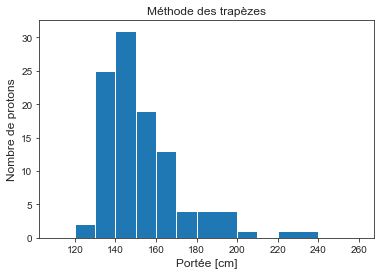

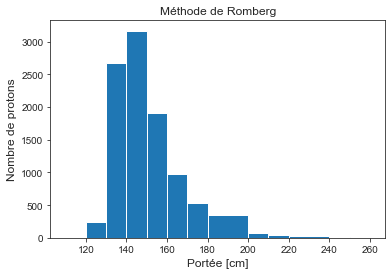

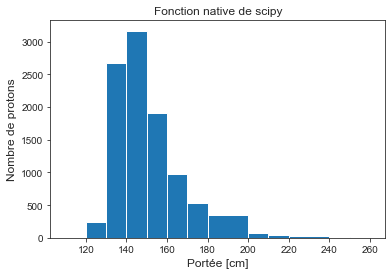

In [103]:
groupes_2 = [110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 240, 250, 260]

sns.set_style("ticks")

plt.figure(figsize=(6,4))
plt.hist(portees_trapeze, bins=groupes_2)
plt.title("Méthode des trapèzes", fontsize=12)
plt.xlabel('Portée [cm]', fontsize=12)
plt.ylabel('Nombre de protons', fontsize=12)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(portees_romberg, bins=groupes_2)
plt.title("Méthode de Romberg", fontsize=12)
plt.xlabel('Portée [cm]', fontsize=12)
plt.ylabel('Nombre de protons', fontsize=12)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(portees_scipy, bins=groupes_2)
plt.title("Fonction native de scipy", fontsize=12)
plt.xlabel('Portée [cm]', fontsize=12)
plt.ylabel('Nombre de protons', fontsize=12)
plt.show()

$$\textcolor{red}{\text{Parler de la distribution}}$$

## Énergie déposée

Comme le but de caractériser le passage des protons dans le milieu est important pour les applications en protonthérapie, on veut maintenant caractériser le dépôt d'énergie dans le milieu. On sait que, lorsque le proton passe d'une énergie $T_i$ à une énergie $T_f$, le pas de déplacement $s$ du proton est donné par
$$s = \int_{T_f}^{T_i}\frac{\text{d}T'}{S_{col}}$$
Pour un pas infinitésimal $\text{d}s$, on a donc
$$\text{d}s = \frac{\text{d}T'}{S_{col}(T)}$$
$$\text{d}T' = S_{col}(T)\text{d}s$$
On a donc une expression pour le dépôt infinitésimal d'énergie pour un pas infinitésimal à une énergie $T$ donnée. La fonction *energie_dep* représente cette expression en prenant en argument une valeur de pas $\text{d}s$, une énergie cinétique initiale $T_i$ et le milieu de propagation. Elle retourne ensuite un *array numpy* à 1 dimensions de valeurs de profondeur allant de 0 à 20 cm avec une liste de valeurs d'énergie déposée. La fonction calcule de façon itérative l'énergie déposée pour chaque pas et soustrait la valeur calculée à l'énergie cinétique du proton avant la prochaine itération. Le processus itératif arrête lorsque la valeur d'énergie cinétique est égale ou inférieure à $T_f$. On considère donc l'énergie cinétique de tout proton ayant une énergie cinétique égale ou inférieur à $T_f$ comme nulle.

In [87]:
# Retourne l'énergie déposée en fonction de la profondeur [cm] et [MeV]
# T_i : énergie cinétique initiale [MeV]
# T_f : valeur minimale d'énergie [MeV]
# ds : longueur du pas [cm], 15 doit être un multiple de ds
# mil : milieu de propagation ("eau" ou "os")

def energie_dep(T_i, T_f, ds, mil):
    N = 15 / ds
    x = np.linspace(0, 15, int(N))
    T = T_i
    dT = []
    for i in x:
        if T > 3:
            dT.append(pouvoir_arret(T, mil) / 100)
            T = T - pouvoir_arret(T, mil) * ds/100
        else:
            dT.append(0)
    return x, dT

On peut maintenant déterminer l'énergie déposée en foonction de la profondeur pour un proton ayant une énergie initiale de 150 MeV. Comme notre modèle théorique ne représente pas bien la réalité pour des protons ayant une énergie égale ou inférieure à 3 MeV, on utilise cette valeur comme borne inférieure. On utilise un pas de 0,01 mm. On trace l'énergie déposée obtenue en fonction de la profondeur.

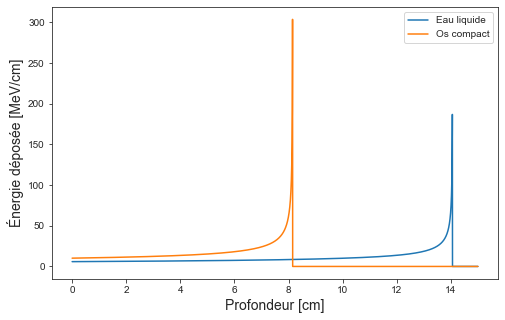

In [88]:
# Eau liquide
x_e, dT_e = energie_dep(150, 3, 0.001, "eau")

# Os compact
x_o, dT_o = energie_dep(150, 3, 0.001, "os")

sns.set_style("ticks")
energie_dep_fig = plt.figure(figsize=(8,5))
plt.plot(x_e, dT_e, label='Eau liquide')
plt.plot(x_o, dT_o, label='Os compact')
plt.xlabel('Profondeur [cm]', fontsize=14)
plt.ylabel("Énergie déposée [MeV/cm]", fontsize=14)
plt.legend()
plt.show()

On observe que l'énergie déposée dans l'os compact tombe à 0 autour de 8 cm, tandis que celle dans l'eau liquide tombe à 0 autour de 14 cm. Cela est conforme avec les portées calculées plus haut, qui étaient de ($\textcolor{red}{\text{Ici va falloir ajouter du stock quand on aura le 5 et 6}}$).

On remarque également que l'énergie déposée augmente drastiquement lorsque l'énergie cinétique du proton est faible. Ce comportement ce nomme le pic de Bragg du proton ($\textcolor{red}{\text{Sources?}}$) et a des applications importantes en protonthérapie. Lorsque l'on envoie des protons dans un patient, on veut causer le plus de dommages possibles à la tumeur ciblée tout en causant le moins de dommages possibles au reste du corps. Grâce au comportement des protons, il est possible de leur donner une énergie cinétique particulière afin que le pic de Bragg se situe dans la zone ciblée. Ce faisant, on maximise le dépot d'énergie et donc les dommages causés dans la zone ciblée tout en minimisant le dépot d'énergie sur le reste du trajet du proton.
$$\textcolor{red}{\text{Ajouter du stock?}}$$

Toutefois, il n'est pas nécessaire de calculer la portée des protons jusqu'à la précision machine en protonthérapie, car ce calcul ne serait pas significatif de toute façon. Tout d'abord, notre modèle théorique ne représente pas bien ce que se passe lorsque la proton a une énergie inférieur à 3 MeV et ne tient pas compte de toutes les causes du pouvoir d'arrêt, donc il y a plusieurs incertitudes qui sont plus importantes que la précision machine. Même si utilisait un modèle théorique qui nous permet de calculer la portée du proton jusqu'à une énergie de 0 MeV avec la précision machine, ce calcul serait quand même beaucoup plus précis que nécessaire, car les faisceaux de protons utilisés en pratique vont varier de plus que la précision machine. En effet, la variation dans la portée d'un faisceau de protons d'une énergie cinétique de 50 MeV est d'environ 1 mm, ce qui est environ $\textcolor{red}{\text{ajouter la bonne valeur ici}}$ fois plus grand que la précision machine. Il n'y a donc pas de raisons pratiques de calculer la portée avec une telle présicion. $\textcolor{red}{\text{Source : https://www.jkps.or.kr/journal/view.html?doi=10.3938/jkps.55.1673}}$

À cause de sa grande précision dans son dépot d'énergie, la protonthérapie est souvent utilisée pour traiter les mélanomes oculaires. Cette méthode de traitement permet de causer des dommages à la tumeur en déposant moins d'énergie dans les structures sensibles de l'oeil ($\textcolor{red}{\text{Source : https://jamanetwork.com/journals/jamaophthalmology/fullarticle/2657208}}$). La radiothérapie classique, qui consiste à envoyer des photons sur la tumeur, cause plus de dommages aux tissus non ciblés. En effet, en protonthérapie, les dommages aux tissus en santé seraient réduis de 60 % ($\textcolor{red}{\text{Source : https://www.medicalnewstoday.com/...}}$)par rapport à l'envoi de photons. Cet effet est causé entre autres par le pic de Bragg des protons, qui permet de concentrer le dépôt d'énergie. Cette caractéristique est très importante dans le cas d'un mélanome oculaire, car elle permet de mieux protéger les structures de l'oeil qui sont en santé.
$$\textcolor{red}{\text{Ajouter du stock?}}$$

Dans notre modèle, il est important de souligner que nous avons considéré que les protons voyagaient simplement en ligne droite dans la matière. Ce n'est évidemment pas totalement réaliste, car les interactions entre les protons est les électrons du milieu peuvent faire dévier le proton de sa trajectoire. Pour améliorer notre modèle, il faudrait modéliser la trajectoire des protons en 3D en prenant en compte les effets qui peuvent modifier la trajectoire de celui-ci. On pourrait alors avoir une meilleure idée de la proportion de protons qui seront déviés de leur trajectoire et de la distribution du dépôt d'énergie en 3D. Il serait important de modéliser ces aspects pour des traitements en protonthérapie, car elles permettraient d'évaluer les dommages possibles causés aux structures qui ne se situent pas directement sur la trajectoire du faisceau de protons.
$$\textcolor{red}{\text{Ajouter du stock?}}$$

# ANCIEN STOCK PAS RAPPORT

On crée d'abord une fonction qui calcule le pas de déplacement en fonction de l'énergie transférée au milieu:

In [89]:
# Retourne le pas du proton pour une variation d'énergie
# Arguments :
# T_i : énergie du proton avant le pas
# T_f : énergie du proton après le pas
# mil : milieu de propagation ("eau" ou "os")

def pas(T_i, T_f, mil):
    def fonction(T):
         return inv_pouvoir_arret(T, mil)
    return sp.integrate.quad(fonction, T_f, T_i)[0]

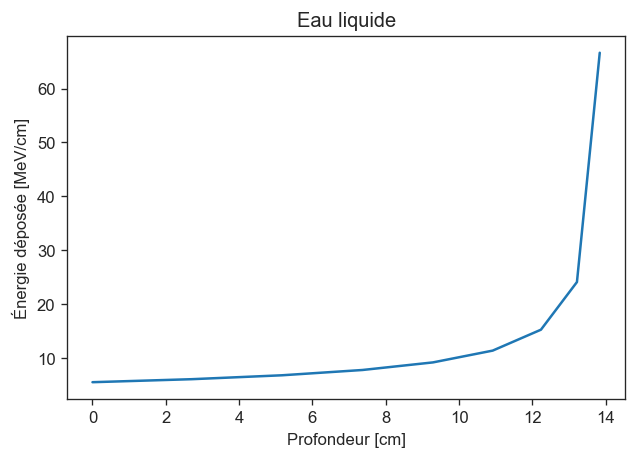

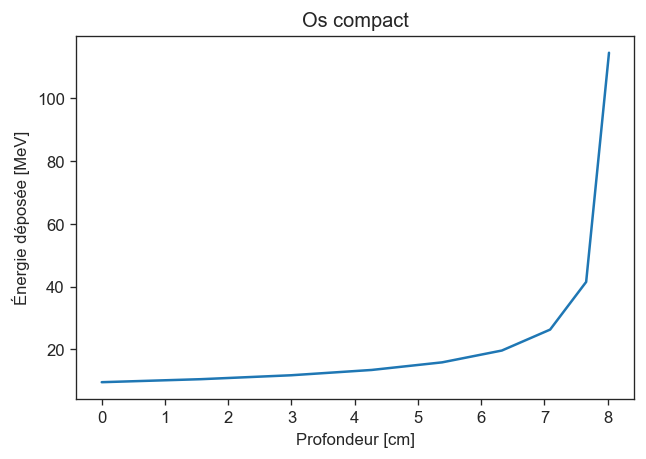

In [90]:
def energie_deposee(T_i, T_f, mil, n):
    s = []
    x = []
    T = np.linspace(T_f, T_i, n)
    depot = []
    for i in range(n-1):
        s.append(pas(T[-i-1], T[-i-2], mil) * 100)
        x.append(sum(s[:-1]))
        depot.append(T_i/n / s[-1])
    return depot, x


# Eau liquide
d_e, x_e = energie_deposee(150, 0, 'eau', 10)

plt.figure(dpi=120)
plt.title("Eau liquide")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV/cm]")
plt.plot(x_e, d_e)
plt.show()

# Os compact
d_o, x_o = energie_deposee(150, 0, 'os', 10)

plt.figure(dpi=120)
plt.title("Os compact")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV]")
plt.plot(x_o, d_o)
plt.show()

On conçoit ensuite un algorithme qui détermine l'énergie déposée par le proton selon la position de celui-ci:

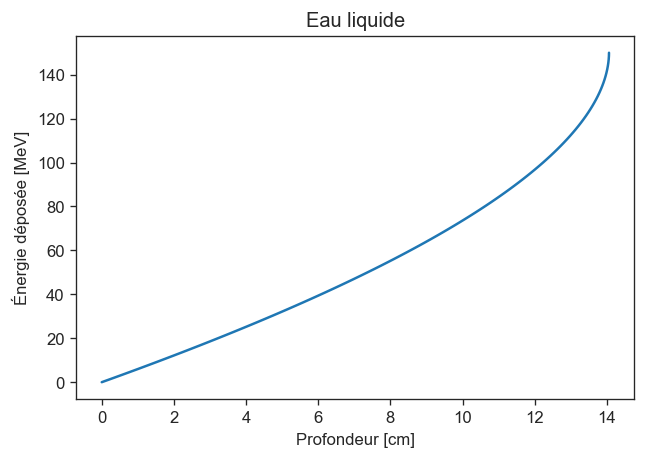

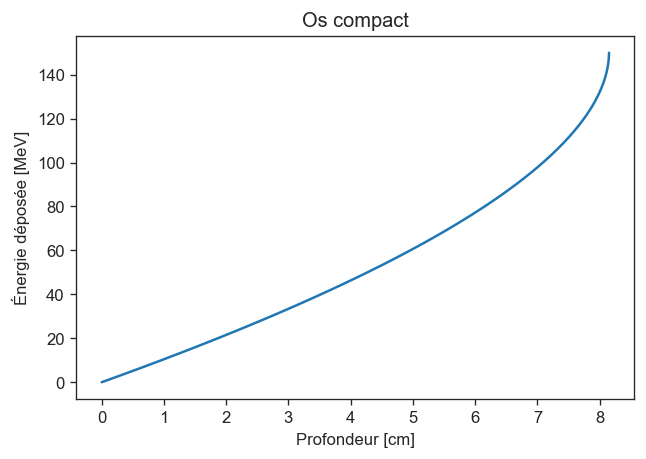

In [91]:
def energie_deposee(T_i, T_f, mil, n):
    s = []
    T = np.linspace(T_f, T_i, n)
    for i in range(n):
        s.append(pas(T_i, T[n-i-1], mil) * 100)
    return T, s

# Eau liquide
T_e, s_e = energie_deposee(150, 0, 'eau', 100)

plt.figure(dpi=120)
plt.title("Eau liquide")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV]")
plt.plot(s_e, T_e)
plt.show()

# Os compact
T_o, s_o = energie_deposee(150, 0, 'os', 100)

plt.figure(dpi=120)
plt.title("Os compact")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV]")
plt.plot(s_o, T_o)
plt.show()

## Médiagraphie

[1] NIST. “Fundamental Physical Constants from NIST.” Consulté le 15 février 2022. https://physics.nist.gov/cuu/Constants/.

[2] NIST. “Compositions of Materials Used in STAR Databases.” Consulté le 15 février 2022. https://physics.nist.gov/cgi-bin/Star/compos.pl?ap.

[3] NIST. “Stopping-power and range tables for protons”. Consulté le 16 février 2022. https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.

[4] NIST. “Stopping-power and range tables for electrons”. Consulté le 16 février 2022. https://physics.nist.gov/PhysRefData/Star/Text/ESTAR.html.

[5] NEWMANN, M. 2013. “Computational physics - Revised and expanded”. Section 5.4 : *Romberg integration*.

[6] NEWMANN, M. 2013. “Computational physics - Revised and expanded”. Section 5.2 : *Errors on integrals*.